In [0]:
%tensorflow_version  1.x

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [5]:
!ls /content/gdrive/My\ Drive/Colab\ Notebooks

 cifar10vgg.h5
'Copy of Welcome To Colaboratory'
 Learn_Estimators_Experiment_Dataset.ipynb
'pretrained model knowledge distillation.ipynb'
 VQ-VAE-FC.ipynb
 VQ-VAE.ipynb


In [0]:
import keras
import tensorflow as tf
import numpy as np

from keras.datasets import cifar10
from keras.utils import np_utils

from keras.layers import MaxPooling2D, Dropout, Dense, Flatten, Activation, Conv2D, Input, concatenate, Lambda, BatchNormalization
from keras.models import Model, Sequential, load_model
from keras.losses import categorical_crossentropy, mae, kullback_leibler_divergence
from keras.metrics import categorical_accuracy
from keras.optimizers import adam, SGD, RMSprop
from keras import backend as K
from keras import regularizers

import matplotlib.pyplot as plt

### Paths

In [0]:
weights_cifar10 = F'/content/gdrive/My\ Drive/Colab\ Notebooks/cifar10vgg.h5'

### Loading data - CIFAR 10

In [8]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# one hot encoding
Y_train = np_utils.to_categorical(y_train)
Y_test = np_utils.to_categorical(y_test)

print("Shape training set: ", X_train.shape)
print("Shape test set: ", X_test.shape)

170500096/170498071 [==============================] - 2s 0us/step
Shape training set:  (50000, 32, 32, 3)
Shape test set:  (10000, 32, 32, 3)


In [0]:
NUMBER_CLASSES = len(np.unique(y_train))
EPOCHS_T = 10
EPOCHS_S = 30
BATCH_SIZE = 128
TEMP = 7

In [10]:
def build_model_vgg16(x_shape=[32,32,3], num_classes=NUMBER_CLASSES, weight_decay=0.0005):
        # Build the network of vgg for 10 classes with massive dropout and weight decay as described in the paper.

        #model = Sequential()
        weight_decay = weight_decay
        image_input = Input(shape=x_shape, dtype='float32', name='input')
        
        l = Conv2D(64, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay))(image_input)
        l = Activation('relu')(l)
        l = BatchNormalization()(l)
        l = Dropout(0.3)(l)

        l = Conv2D(64, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay))(l)
        l = Activation('relu')(l)
        l = BatchNormalization()(l)

        l = MaxPooling2D(pool_size=(2, 2))(l)

        l = Conv2D(128, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay))(l)
        l = Activation('relu')(l)
        l = BatchNormalization()(l)
        l = Dropout(0.4)(l)

        l = Conv2D(128, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay))(l)
        l = Activation('relu')(l)
        l = BatchNormalization()(l)

        l = MaxPooling2D(pool_size=(2, 2))(l)

        l = Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay))(l)
        l = Activation('relu')(l)
        l = BatchNormalization()(l)
        l = Dropout(0.4)(l)

        l = Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay))(l)
        l = Activation('relu')(l)
        l = BatchNormalization()(l)
        l = Dropout(0.4)(l)

        l = Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay))(l)
        l = Activation('relu')(l)
        l = BatchNormalization()(l)

        l = MaxPooling2D(pool_size=(2, 2))(l)


        l = Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay))(l)
        l = Activation('relu')(l)
        l = BatchNormalization()(l)
        l = Dropout(0.4)(l)

        l = Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay))(l)
        l = Activation('relu')(l)
        l = BatchNormalization()(l)
        l = Dropout(0.4)(l)

        l = Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay))(l)
        l = Activation('relu')(l)
        l = BatchNormalization()(l)

        l = MaxPooling2D(pool_size=(2, 2))(l)


        l = Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay))(l)
        l = Activation('relu')(l)
        l = BatchNormalization()(l)
        l = Dropout(0.4)(l)

        l = Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay))(l)
        l = Activation('relu')(l)
        l = BatchNormalization()(l)
        l = Dropout(0.4)(l)

        l = Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay))(l)
        l = Activation('relu')(l)
        l = BatchNormalization()(l)

        l = MaxPooling2D(pool_size=(2, 2))(l)
        l = Dropout(0.5)(l)

        l = Flatten()(l)
        l = Dense(512,kernel_regularizer=regularizers.l2(weight_decay))(l)
        l = Activation('relu')(l)
        l = BatchNormalization()(l)

        l = Dropout(0.5)(l)
        l = Dense(num_classes)(l)
        output = Activation('softmax')(l)
        
        model = Model(
        inputs=[image_input], 
        outputs=[output])
        
        return model
    
model = build_model_vgg16()
model.summary()












Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        36928    

### Define TEACHER

In [0]:
model.load_weights('./gdrive/My Drive/Colab Notebooks/cifar10vgg.h5')

In [0]:
teacher_before_softmax = Model(model.input, model.get_layer('dense_2').output)

In [0]:
def normalize_production(x):
        #this function is used to normalize instances in production according to saved training set statistics
        # Input: X - a training set
        # Output X - a normalized training set according to normalization constants.

        #these values produced during first training and are general for the standard cifar10 training set normalization
        mean = 120.707
        std = 64.15
        
        return (x-mean)/(std+1e-7)

In [0]:
def softmax(x):
    return np.exp(x)/(np.exp(x).sum())

In [15]:
y_test[100]

array([4])

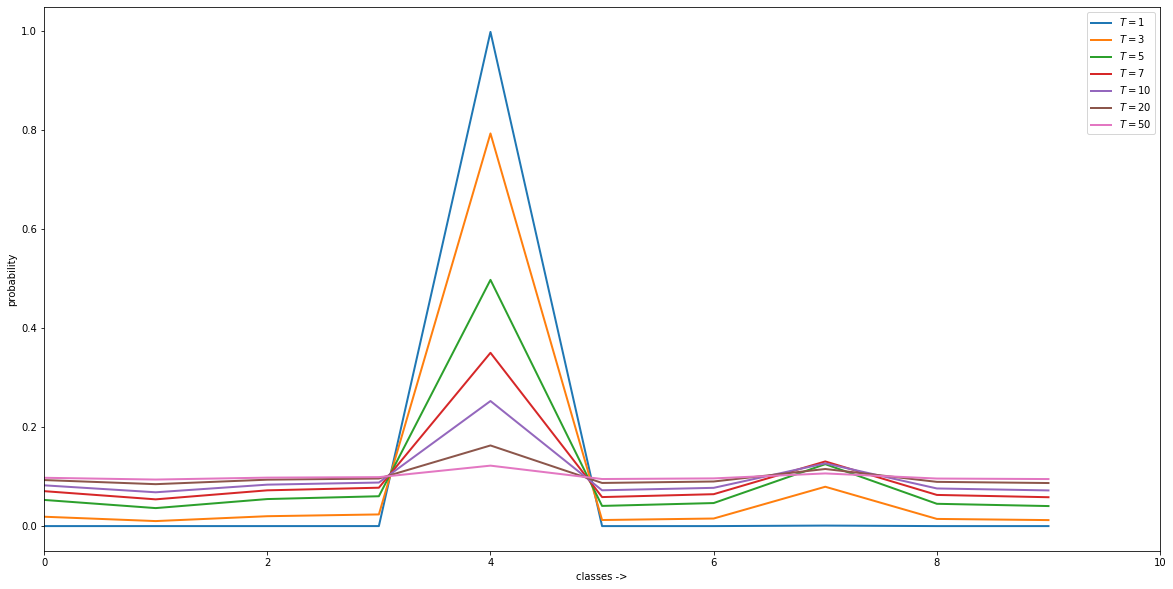

In [16]:
intermediate_output = teacher_before_softmax.predict(normalize_production(X_test[100].reshape(1,32,32,3)))


# logits for the first number in test dataset
x = intermediate_output[0]
plt.figure(figsize=(20, 10));

temperature = [1, 3, 5, 7, 10, 20, 50]

for temp in temperature:

    plt.plot((softmax(x/temp)), label='$T='+str(temp)+'$', linewidth=2);
    plt.legend();
plt.xlabel('classes ->');
plt.ylabel('probability');
plt.xlim([0, 10]);
plt.show()


### Create soft targets for student to be trained on

In [0]:
TEMP = 5

teacher_logits_train = teacher_before_softmax.predict(X_train)
teacher_logits_test = teacher_before_softmax.predict(X_test)

temp_logits_train = teacher_logits_train / TEMP
temp_logits_test = teacher_logits_test / TEMP

# soft labels
soft_y_train = softmax(temp_logits_train)
soft_y_test = softmax(temp_logits_test)

# concatenate soft to hard labels
Y_train_new = np.concatenate([Y_train, soft_y_train], axis=1)
Y_test_new =  np.concatenate([Y_test, soft_y_test], axis =1)

In [35]:
print("New shape training set: ", Y_train_new.shape)
print("New shape test set: ", Y_test_new.shape)

New shape training set:  (50000, 20)
New shape test set:  (10000, 20)


### Loss function for STUDENT

In [0]:
def knowledge_distillation_loss(y_true, y_pred, alpha, number_classes=NUMBER_CLASSES, temp=TEMP):
    hard_true_y, soft_true_y = y_true[:,:number_classes], y_true[:,number_classes:]
    hard_pred_y, soft_pred_y = y_pred[:,:number_classes], y_pred[:,number_classes:]
    
    loss = alpha*categorical_crossentropy(hard_true_y, hard_pred_y) + categorical_crossentropy(soft_true_y, soft_pred_y)
    
    #(1-alpha)*categorical_crossentropy(hard_true_y, hard_pred_y) + alpha*temp*temp*kullback_leibler_divergence(soft_true_y, soft_pred_y)
    #alpha*categorical_crossentropy(hard_true_y, hard_pred_y) + mae(soft_true_y, soft_pred_y) 
    #alpha*categorical_crossentropy(hard_true_y, hard_pred_y) + categorical_crossentropy(soft_true_y, soft_pred_y)
    
    return loss

# selecting right info for accuracy
def accuracy(y_true, y_pred, number_classes=NUMBER_CLASSES):
    hard_true_y = y_true[:,:number_classes]
    hard_pred_y = y_pred[:,:number_classes]
    
    return categorical_accuracy(hard_true_y, hard_pred_y)

### STUDENT

### Define similar Student model for comparison outside of knowledge distillation

In [64]:
def build_model_vgg6(x_shape=[32,32,3], num_classes=NUMBER_CLASSES, weight_decay=0.0005):

        weight_decay = weight_decay
        image_input = Input(shape=x_shape, dtype='float32', name='input')
        
        l = Conv2D(64, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay))(image_input)
        l = Activation('relu')(l)
        l = BatchNormalization()(l)
        l = Dropout(0.3)(l)

        l = Conv2D(64, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay))(l)
        l = Activation('relu')(l)
        l = BatchNormalization()(l)

        l = MaxPooling2D(pool_size=(2, 2))(l)

        l = Conv2D(128, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay))(l)
        l = Activation('relu')(l)
        l = BatchNormalization()(l)
        l = Dropout(0.4)(l)

        l = Conv2D(128, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay))(l)
        l = Activation('relu')(l)
        l = BatchNormalization()(l)

        l = MaxPooling2D(pool_size=(2, 2))(l)

        l = Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay))(l)
        l = Activation('relu')(l)
        l = BatchNormalization()(l)
        l = Dropout(0.4)(l)

        l = Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay))(l)
        l = Activation('relu')(l)
        l = BatchNormalization()(l)
        l = Dropout(0.4)(l)

        l = Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay))(l)
        l = Activation('relu')(l)
        l = BatchNormalization()(l)

        l = MaxPooling2D(pool_size=(2, 2))(l)
#===

#         l = Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay))(l)
#         l = Activation('relu')(l)
#         l = BatchNormalization()(l)
#         l = Dropout(0.4)(l)

#         l = Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay))(l)
#         l = Activation('relu')(l)
#         l = BatchNormalization()(l)
#         l = Dropout(0.4)(l)

#         l = Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay))(l)
#         l = Activation('relu')(l)
#         l = BatchNormalization()(l)

#         l = MaxPooling2D(pool_size=(2, 2))(l)


#         l = Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay))(l)
#         l = Activation('relu')(l)
#         l = BatchNormalization()(l)
#         l = Dropout(0.4)(l)

#         l = Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay))(l)
#         l = Activation('relu')(l)
#         l = BatchNormalization()(l)
#         l = Dropout(0.4)(l)

#         l = Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay))(l)
#         l = Activation('relu')(l)
#         l = BatchNormalization()(l)

#         l = MaxPooling2D(pool_size=(2, 2))(l)

        l = Dropout(0.5)(l)

        l = Flatten()(l)
        l = Dense(512,kernel_regularizer=regularizers.l2(weight_decay))(l)
        l = Activation('relu')(l)
        l = BatchNormalization()(l)

        l = Dropout(0.5)(l)
        l = Dense(num_classes)(l)
        probs = Activation('softmax')(l)
        
        # softed probabilities at raised temperature
        logits_T = Lambda(lambda x: x / temp)(l)
        probs_T = Activation('softmax')(logits_T)

        output = concatenate([probs, probs_T])
        
        model = Model(
        inputs=[image_input], 
        outputs=[output])
        
        return model
    
model_student = build_model_vgg6()
model_student.summary()

Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_98 (Conv2D)              (None, 32, 32, 64)   1792        input[0][0]                      
__________________________________________________________________________________________________
activation_135 (Activation)     (None, 32, 32, 64)   0           conv2d_98[0][0]                  
__________________________________________________________________________________________________
batch_normalization_111 (BatchN (None, 32, 32, 64)   256         activation_135[0][0]             
___________________________________________________________________________________________

### Finding temprature

### Training student

In [0]:
def normalize(X_train,X_test):
   
    mean = np.mean(X_train,axis=(0,1,2,3))
    std = np.std(X_train, axis=(0, 1, 2, 3))
    X_train = (X_train-mean)/(std+1e-7)
    X_test = (X_test-mean)/(std+1e-7)
    
    return X_train, X_test
 
X_train, X_test = normalize(X_train, X_test)

In [0]:
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler

# learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
#                                             patience=3, 
#                                             verbose=1, 
#                                             factor=0.5, 
#                                             min_lr=0.00125)

# def scheduler(epoch):
#   if epoch < 10:
#     return 0.00125
#   else:
#     return 0.00125 * tf.math.exp(0.1 * (10 - epoch))

def lr_scheduler(epoch, lr=0.00125):
    decay_rate = 0.1
    decay_step = 20
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr

learning_rate_scheduler = LearningRateScheduler(lr_scheduler)


In [65]:
model_student.compile(
    optimizer=adam(lr=0.00125), #RMSprop(lr=0.00125),
    loss=lambda y_true, y_pred: knowledge_distillation_loss(y_true, y_pred, 0.2),
    metrics=[accuracy])

model_student.fit(X_train, Y_train_new,
          batch_size=512, #BATCH_SIZE,
          epochs=50, #EPOCHS_S,
          verbose=1,
          callbacks=[learning_rate_scheduler],
          validation_data=(X_test, Y_test_new))

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 31s 629us/step - loss: 1.2839 - accuracy: 0.3719 - val_loss: 1.2031 - val_accuracy: 0.2927
Epoch 2/50
50000/50000 [==============================] - 19s 382us/step - loss: 0.8652 - accuracy: 0.5392 - val_loss: 0.8050 - val_accuracy: 0.4058
Epoch 3/50
50000/50000 [==============================] - 19s 380us/step - loss: 0.6032 - accuracy: 0.6348 - val_loss: 0.6186 - val_accuracy: 0.4902
Epoch 4/50
50000/50000 [==============================] - 19s 378us/step - loss: 0.4563 - accuracy: 0.6922 - val_loss: 0.4818 - val_accuracy: 0.5786
Epoch 5/50
50000/50000 [==============================] - 19s 379us/step - loss: 0.3753 - accuracy: 0.7274 - val_loss: 0.4064 - val_accuracy: 0.6459
Epoch 6/50
50000/50000 [==============================] - 19s 380us/step - loss: 0.3225 - accuracy: 0.7573 - val_loss: 0.3339 - val_accuracy: 0.7330
Epoch 7/50
50000/50000 [==============================] 

In [66]:
model_student.evaluate(X_test, Y_test_new)

10000/10000 [==============================] - 2s 229us/step


[0.12628093029260634, 0.9063]

### smaller models like various students trained on their own

In [67]:
def build_model_vgg6_simple(x_shape=[32,32,3], num_classes=NUMBER_CLASSES, weight_decay=0.0005):

        weight_decay = weight_decay
        image_input = Input(shape=x_shape, dtype='float32', name='input')
        
        l = Conv2D(64, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay))(image_input)
        l = Activation('relu')(l)
        l = BatchNormalization()(l)
        l = Dropout(0.3)(l)

        l = Conv2D(64, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay))(l)
        l = Activation('relu')(l)
        l = BatchNormalization()(l)

        l = MaxPooling2D(pool_size=(2, 2))(l)

        l = Conv2D(128, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay))(l)
        l = Activation('relu')(l)
        l = BatchNormalization()(l)
        l = Dropout(0.4)(l)

        l = Conv2D(128, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay))(l)
        l = Activation('relu')(l)
        l = BatchNormalization()(l)

        l = MaxPooling2D(pool_size=(2, 2))(l)

        l = Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay))(l)
        l = Activation('relu')(l)
        l = BatchNormalization()(l)
        l = Dropout(0.4)(l)

        l = Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay))(l)
        l = Activation('relu')(l)
        l = BatchNormalization()(l)
        l = Dropout(0.4)(l)

        l = Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay))(l)
        l = Activation('relu')(l)
        l = BatchNormalization()(l)

        l = MaxPooling2D(pool_size=(2, 2))(l)
#===

#         l = Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay))(l)
#         l = Activation('relu')(l)
#         l = BatchNormalization()(l)
#         l = Dropout(0.4)(l)

#         l = Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay))(l)
#         l = Activation('relu')(l)
#         l = BatchNormalization()(l)
#         l = Dropout(0.4)(l)

#         l = Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay))(l)
#         l = Activation('relu')(l)
#         l = BatchNormalization()(l)

#         l = MaxPooling2D(pool_size=(2, 2))(l)


#         l = Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay))(l)
#         l = Activation('relu')(l)
#         l = BatchNormalization()(l)
#         l = Dropout(0.4)(l)

#         l = Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay))(l)
#         l = Activation('relu')(l)
#         l = BatchNormalization()(l)
#         l = Dropout(0.4)(l)

#         l = Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay))(l)
#         l = Activation('relu')(l)
#         l = BatchNormalization()(l)

#         l = MaxPooling2D(pool_size=(2, 2))(l)

        l = Dropout(0.5)(l)

        l = Flatten()(l)
        l = Dense(512,kernel_regularizer=regularizers.l2(weight_decay))(l)
        l = Activation('relu')(l)
        l = BatchNormalization()(l)

        l = Dropout(0.5)(l)
        l = Dense(num_classes)(l)
        output = Activation('softmax')(l)
        
        model = Model(
        inputs=[image_input], 
        outputs=[output])
        
        return model
    
model_simple = build_model_vgg6_simple()
model_simple.summary()

Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_105 (Conv2D)          (None, 32, 32, 64)        1792      
_________________________________________________________________
activation_145 (Activation)  (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_119 (Bat (None, 32, 32, 64)        256       
_________________________________________________________________
dropout_89 (Dropout)         (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_106 (Conv2D)          (None, 32, 32, 64)        36928     
_________________________________________________________________
activation_146 (Activation)  (None, 32, 32, 64)        0  

### Testing a model simple as Student model to compare

##### small difference 2-3% roughly

In [69]:
model_simple.compile(loss='categorical_crossentropy',
              optimizer=adam(lr=0.00125),
              metrics=['accuracy'])

model_simple.fit(X_train, Y_train,
          batch_size=512,
          epochs=50,
          verbose=1,
          callbacks=[learning_rate_scheduler],
          validation_data=(X_test, Y_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 32s 636us/step - loss: 2.9788 - acc: 0.3581 - val_loss: 3.5268 - val_acc: 0.3095
Epoch 2/50
50000/50000 [==============================] - 19s 381us/step - loss: 2.3253 - acc: 0.5195 - val_loss: 2.4753 - val_acc: 0.4847
Epoch 3/50
50000/50000 [==============================] - 19s 377us/step - loss: 1.9779 - acc: 0.6110 - val_loss: 2.0295 - val_acc: 0.5786
Epoch 4/50
50000/50000 [==============================] - 19s 374us/step - loss: 1.7346 - acc: 0.6664 - val_loss: 1.6250 - val_acc: 0.6912
Epoch 5/50
50000/50000 [==============================] - 19s 375us/step - loss: 1.5262 - acc: 0.7158 - val_loss: 1.5515 - val_acc: 0.6961
Epoch 6/50
50000/50000 [==============================] - 19s 376us/step - loss: 1.3717 - acc: 0.7483 - val_loss: 1.4432 - val_acc: 0.7206
Epoch 7/50
50000/50000 [==============================] - 19s 376us/step - loss: 1.2513 - acc: 0.7713 - val_loss: 1.

### No. parameters

In [72]:
print("Teacher parameters: %d" % model.count_params())
print("Student parameters: %d" % model_student.count_params())
print("Simple model parameters: %d" % model_simple.count_params())
print(model.count_params() / model_student.count_params())

Teacher parameters: 15001418
Student parameters: 3844938
Simple model parameters: 3844938
3.90160205444145
